# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import spacy
import torch
import transformers

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:

display(df_reviews.sample(10))
df_reviews.info()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
8979,tt0451109,movie,Dark Harvest II: The Maize,The Maize: The Movie,2004,\N,100,0,Horror,1.9,2577,Besides the comments on the technical merits o...,1,neg,0,test,4195
36176,tt0082252,movie,The Decline of Western Civilization,The Decline of Western Civilization,1981,\N,100,0,"Documentary,History,Music",7.6,3448,I saw this movie in the theater when I was 14 ...,10,pos,1,test,11677
26367,tt0117342,movie,Pinocchio's Revenge,Pinocchio's Revenge,1996,\N,96,0,"Fantasy,Horror",4.0,1945,this movie is the best horror movie i have eve...,10,pos,1,test,10542
5093,tt0091561,movie,Blood Theatre,Blood Theatre,1984,\N,75,0,"Comedy,Horror",2.8,507,To truly appreciate this film you had to be th...,1,neg,0,test,6849
12535,tt0455949,movie,Favela Rising,Favela Rising,2005,\N,80,0,Documentary,7.2,625,"Unlike the previous poster, I liked the cellul...",10,pos,1,test,10704
38729,tt0084234,movie,The Last American Virgin,The Last American Virgin,1982,\N,92,0,"Comedy,Drama,Romance",6.3,7613,"Yes it's a Fast Times wannabe, but it's still ...",7,pos,1,test,10451
20168,tt0345551,movie,Latter Days,Latter Days,2003,\N,107,0,"Comedy,Drama,Romance",7.0,16678,"First of all, I'd like to say I'm just an amat...",10,pos,1,test,8166
13821,tt0050414,movie,From Hell It Came,From Hell It Came,1957,\N,71,0,"Horror,Sci-Fi",3.7,1284,**May Contain Spoilers** A luckless South Sea ...,3,neg,0,test,4410
38341,tt0119395,movie,The Jackal,The Jackal,1997,\N,124,0,"Action,Crime,Drama",6.4,104176,I could not believe how terrible and boring th...,2,neg,0,test,6827
28515,tt0082992,movie,Rich and Famous,Rich and Famous,1981,\N,117,0,Drama,5.9,1494,"George Cuckor, known as a director of women, c...",10,pos,1,test,3113


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

Antes de entrenar el modelo se debe entender la cantidad de reseñas  en total y cuántas en cada conjunto (train vs test),
observar si hay un balance entre reseñas positivas y negativas y cómo luce la longitud de las reseñas Distribución por conjunto de datos:
train    23796
test     23535
Name: ds_part, dtype: int64

Distribución de reseñas positivas y negativas:
0    23715
1    23616
Name: pos, dtype: int64

Tamaño del dataset: (47331, 17)

Distribución por conjunto de datos:
train    23796
test     23535
Name: ds_part, dtype: int64

Distribución de reseñas positivas y negativas:
0    23715
1    23616
Name: pos, dtype: int64


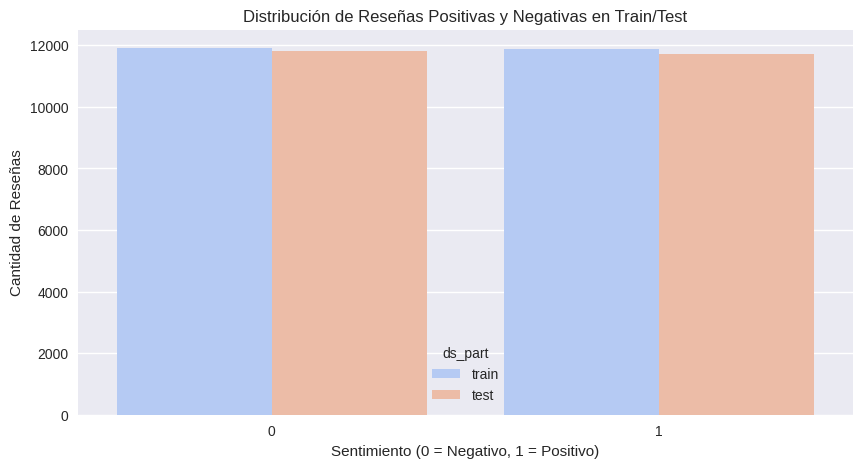

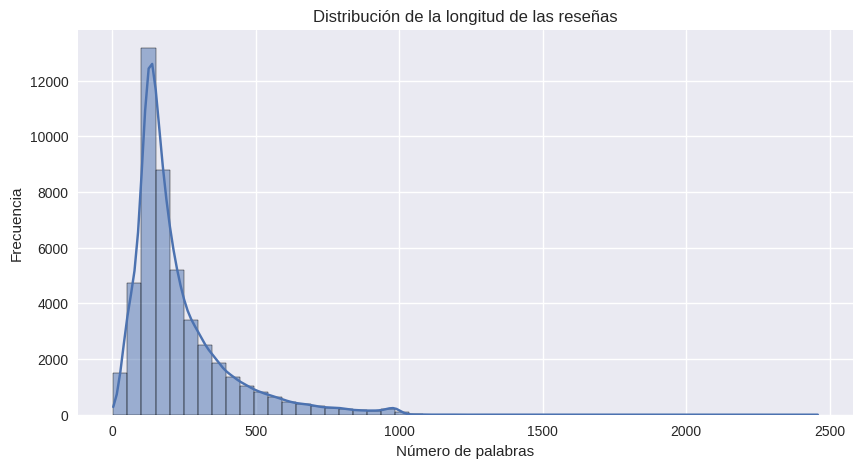

In [7]:
print("Tamaño del dataset:", df_reviews.shape)

# Cantidad de reseñas en train y test
print("\nDistribución por conjunto de datos:")
print(df_reviews['ds_part'].value_counts())

# Cantidad de reseñas positivas y negativas
print("\nDistribución de reseñas positivas y negativas:")
print(df_reviews['pos'].value_counts())

# Visualización de distribución de clases
plt.figure(figsize=(10,5))
sns.countplot(data=df_reviews, x='pos', hue='ds_part', palette='coolwarm')
plt.title("Distribución de Reseñas Positivas y Negativas en Train/Test")
plt.xlabel("Sentimiento (0 = Negativo, 1 = Positivo)")
plt.ylabel("Cantidad de Reseñas")
plt.show()

# Análisis de longitud de reseñas
df_reviews["review_length"] = df_reviews["review"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df_reviews["review_length"], bins=50, kde=True)
plt.title("Distribución de la longitud de las reseñas")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

el modelo de prueba y entrenamiento están equilibrados, esto nos va a ayudar para el tema de evitar sesgos. Hay un número casi idéntico de reseñas positivas y negativas, por lo que nuestro modelo no sufrirá de sesgo hacia una clase en particular.


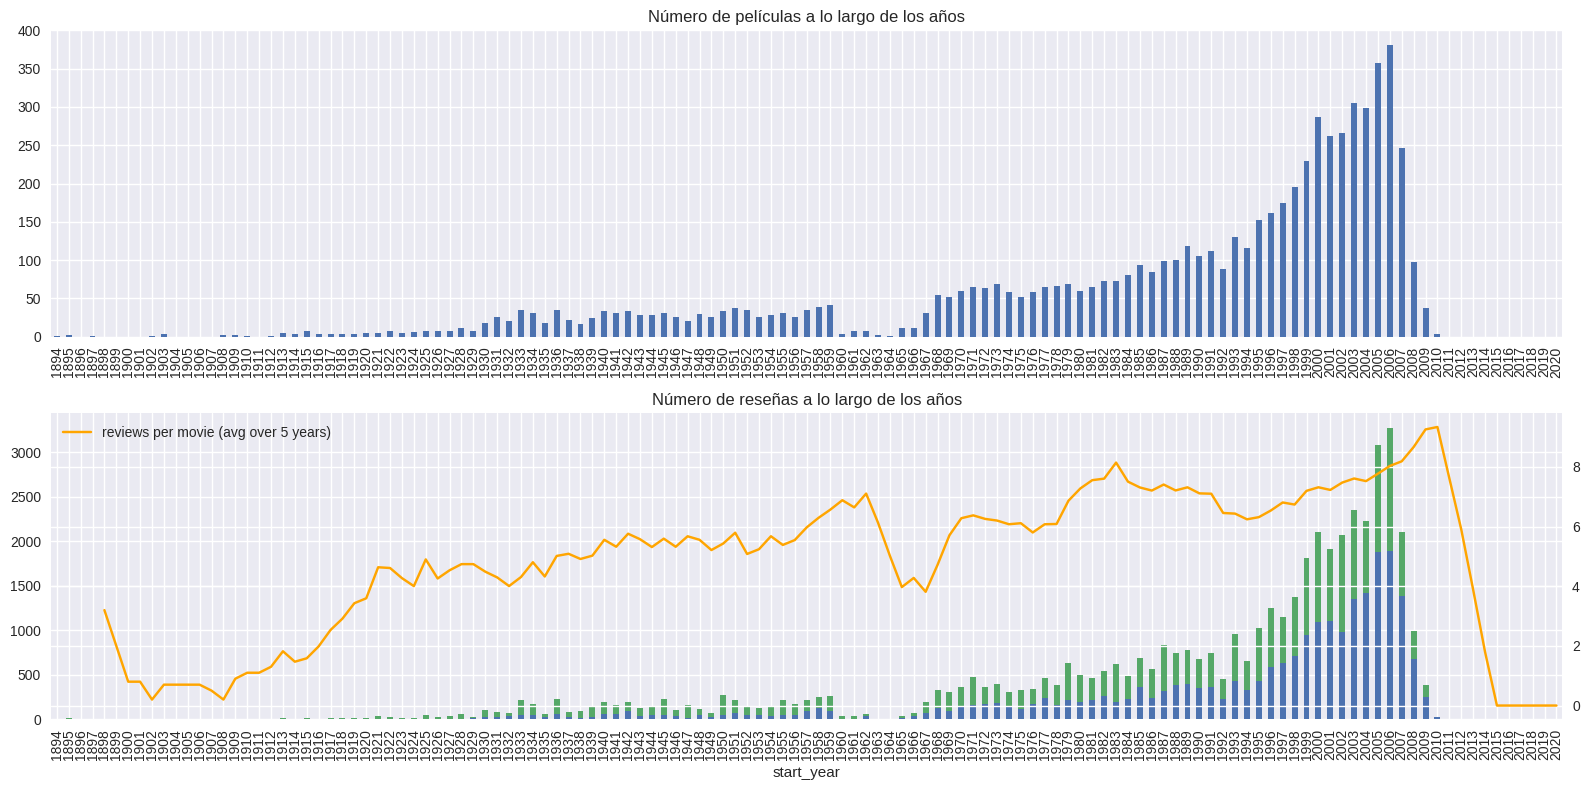

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

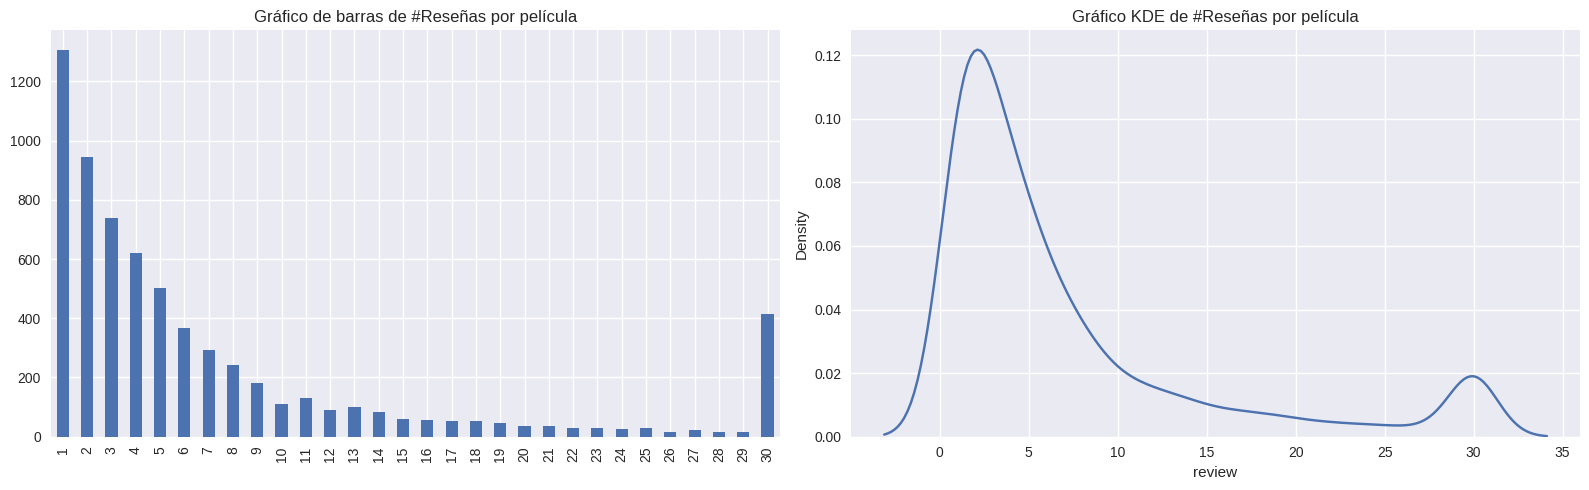

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

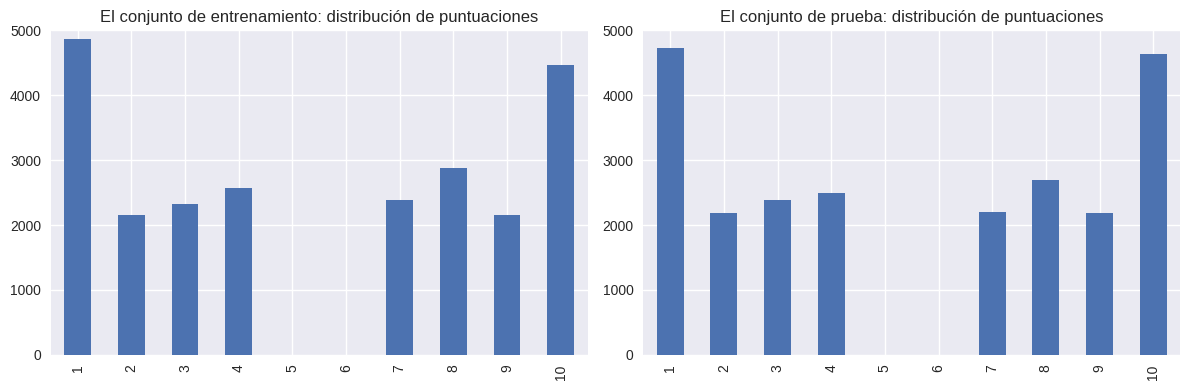

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


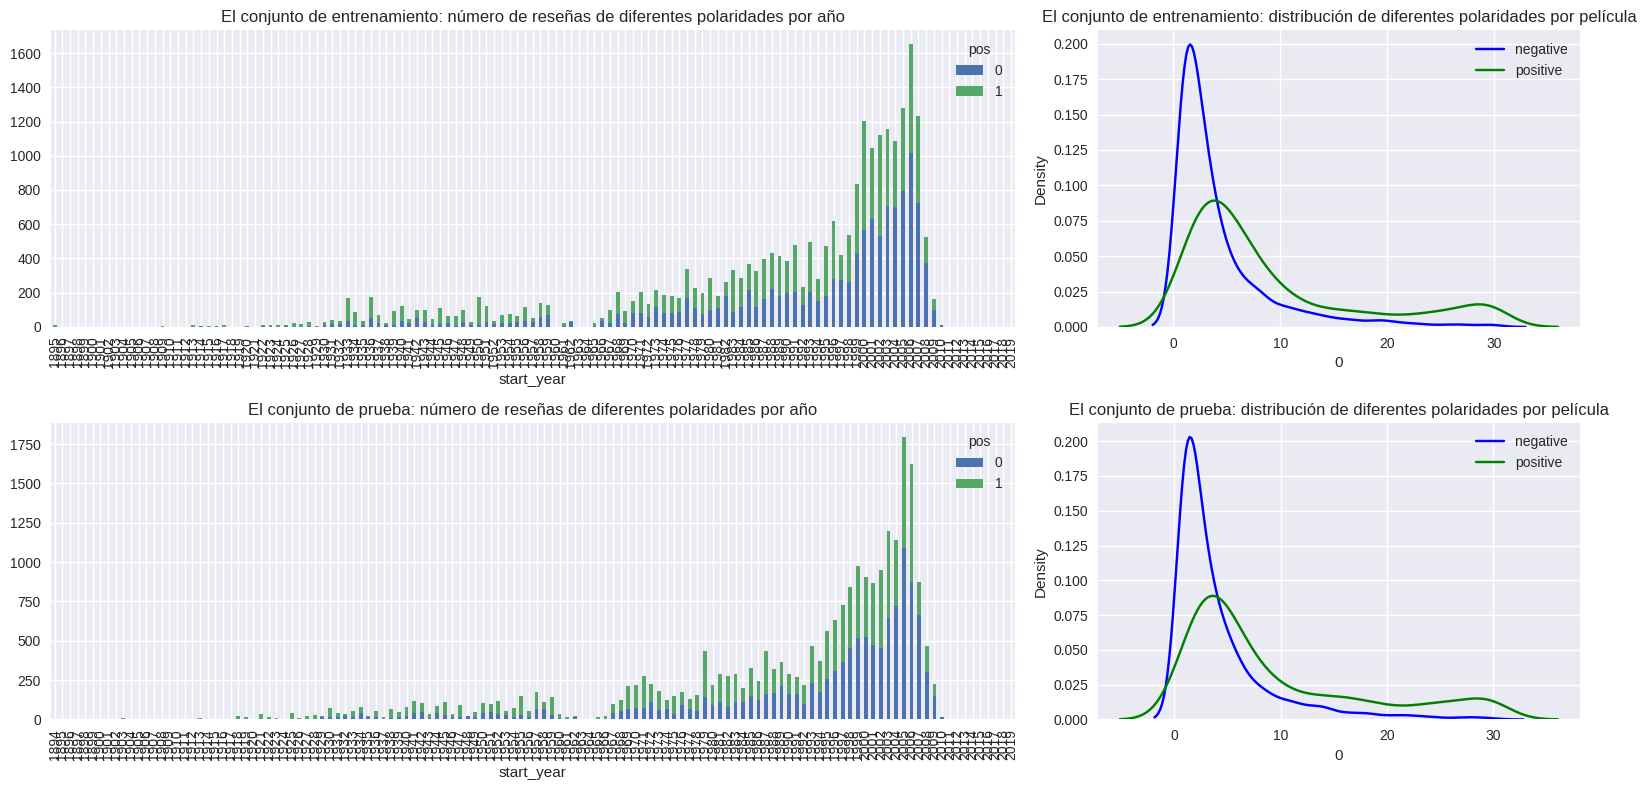

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [13]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

Definiremos la función, clean_string(), para filtrar las reseñas:

Parámetros

texto: Cadena que contiene una reseña de película a procesar.
Devuelve: la reseña de la película sin números, puntuación y espacios adicionales, convertida a minúsculas.

In [14]:
def clean_string(text):
    s = re.sub(r"[^a-zA-Z']", ' ', text)
    return (' '.join(s.split())).lower()

Agregaremos una columna de las revisiones procesadas que se utilizarán para la vectorización/creación de funciones. Imprimiremos cinco muestras para asegurarnos de que el filtro se procese correctamente.

In [15]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_string)
display(df_reviews['review_norm'].sample(5))

18385    this movie was not very entertaining certainly...
10696    i suppose if you like pure action you'll find ...
30544    this low budget b horror's plot comes with all...
42334    as an employee of the swedish air force i enjo...
24866    after nearly getting killed by a big dog a str...
Name: review_norm, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23535, 19)


## Trabajar con modelos

Las revisiones se vectorizarán calculando el TF-IDF (o incrustaciones para el modelo BERT). Los modelos de predicción que compararemos son los siguientes:

LogisticRegression con lemas derivados de NLTK
Regresión logística con lemas derivados spaCy
LGBMClassifier con lemas derivados de spaCy
Regresión logística con BERT
Además, estableceremos una línea de base utilizando un modelo constante.

### Modelo 0 - Constante

           train  test
Exactitud    NaN   NaN
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


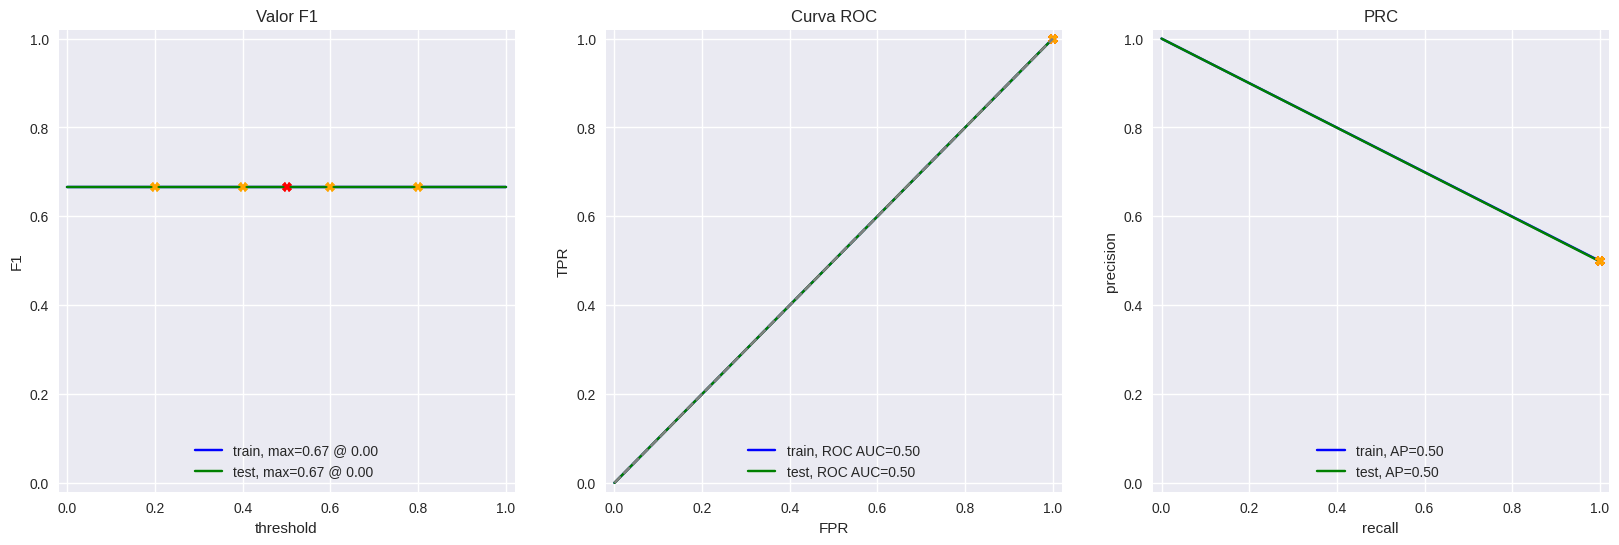

In [17]:
train_features = np.ones(train_target.shape)
test_features = np.ones(test_target.shape)

dummy = DummyClassifier(strategy='constant', random_state=12345, constant=1)
dummy.fit(train_features, train_target)

evaluate_model(dummy, train_features, train_target, test_features, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

Definiremos la función, nltk_lemma_processor(), para lematizar cada revisión usando la biblioteca NLTK, de la siguiente manera:

Parámetros

texto: Cadena de la reseña a lematizar usando NLTK.
Devuelve: Cadena de lemas unidos.

TF-IDF

In [18]:
def nltk_lemma_processor(text):
    lemmatizer  = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lemmas) 

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


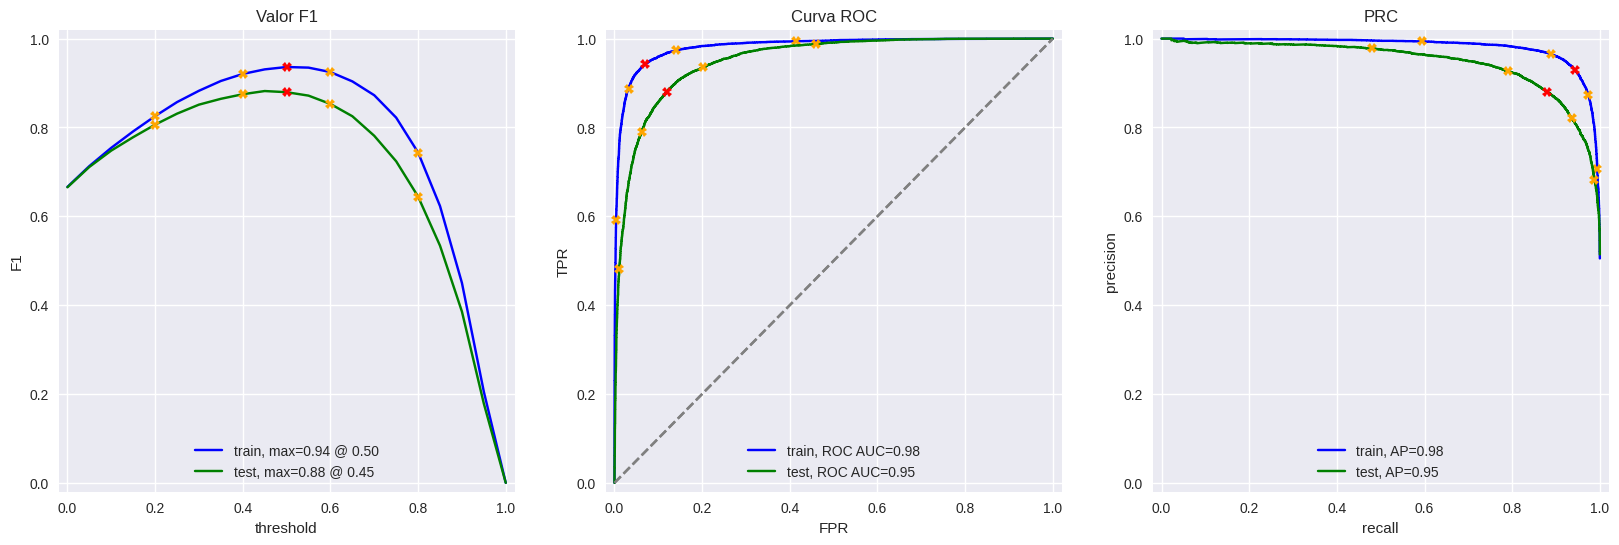

In [19]:
df_reviews_train['nltk_lemma'] = df_reviews_train['review_norm'].apply(nltk_lemma_processor)
df_reviews_test['nltk_lemma'] = df_reviews_test['review_norm'].apply(nltk_lemma_processor)

count_tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'))
nltk_tf_idf = count_tf_idf.fit(df_reviews_train['nltk_lemma'])

train_features = nltk_tf_idf.transform(df_reviews_train['nltk_lemma'])
test_features = nltk_tf_idf.transform(df_reviews_test['nltk_lemma'])

lr_model_nltk = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_nltk.fit(train_features, train_target)

evaluate_model(lr_model_nltk, train_features, train_target, test_features, test_target)

El modelo de regresión logística que utiliza los lemas derivados de NLTK funcionó bien en el conjunto de entrenamiento, pero pareció estar ligeramente sobreajustado cuando se evaluó frente al conjunto de prueba. El modelo aún logró una puntuación superior al umbral de puntuación F1 con un 0,88.

### Modelo 3 - spaCy, TF-IDF y LR


Primero cargaremos la tubería spaCy del modelo inglés de tamaño pequeño para procesar las revisiones.

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

De manera similar a la función de lematización NLTK, definiremos spacy_lemma_processor(), para facilitar la conversión de tokens en lemas usando spaCy:

Parámetros

texto: Cadena de la reseña a lematizar usando spaCy.
Devuelve: Cadena de lemas unidos.

In [21]:
def spacy_lemma_processor(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
          
    return ' '.join(tokens)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.94
ROC AUC     0.98  0.95


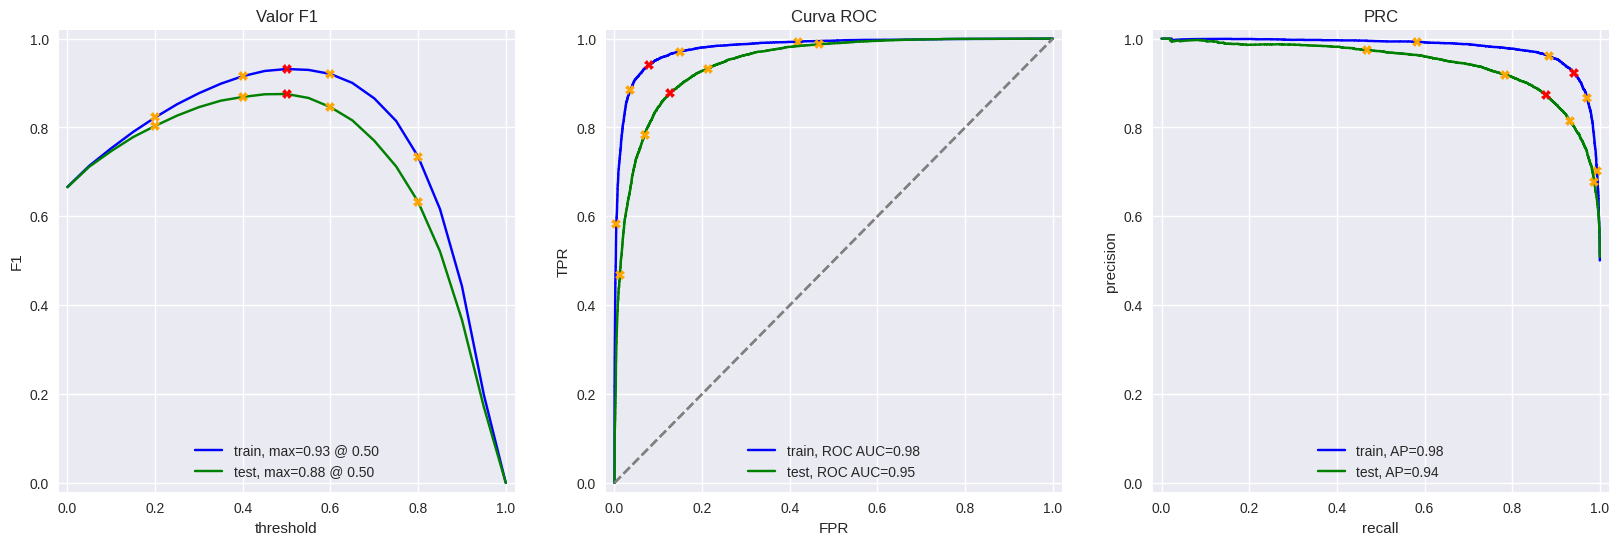

In [22]:
df_reviews_train['spacy_lemma'] = df_reviews_train['review_norm'].apply(spacy_lemma_processor)
df_reviews_test['spacy_lemma'] = df_reviews_test['review_norm'].apply(spacy_lemma_processor)

count_tf_idf = TfidfVectorizer()
spacy_tf_idf = count_tf_idf.fit(df_reviews_train['spacy_lemma'])

train_features = spacy_tf_idf.transform(df_reviews_train['spacy_lemma'])
test_features = spacy_tf_idf.transform(df_reviews_test['spacy_lemma'])

lr_model_spacy = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_spacy.fit(train_features, train_target)

evaluate_model(lr_model_spacy, train_features, train_target, test_features, test_target)

El modelo de regresión logística que utiliza los lemas derivados de spaCy pareció tener un rendimiento similar, con una precisión y puntuaciones F1 ligeramente inferiores en los conjuntos de entrenamiento y de prueba. El modelo aún se desempeñó por encima del umbral de puntuación F1.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

Podemos usar los lemas anteriores creados desde spaCy y entrenar el siguiente modelo.

           train  test
Exactitud    NaN   NaN
F1          0.91  0.85
APS         0.97  0.93
ROC AUC     0.97  0.93


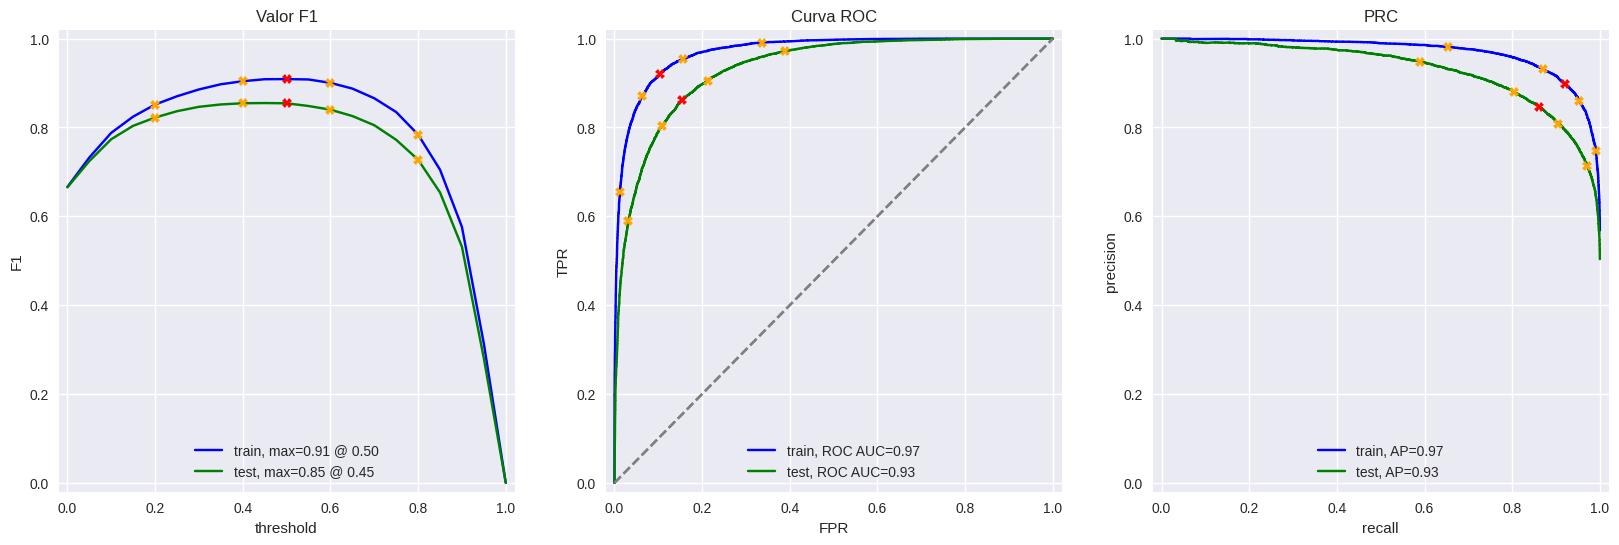

In [23]:
lgbm_model = LGBMClassifier(random_state=12345, n_jobs=-1)
lgbm_model.fit(train_features, train_target)

evaluate_model(lgbm_model, train_features, train_target, test_features, test_target)

###  Modelo 9 - BERT

In [24]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks  
    for input_text in texts:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # get embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):        
        ids_batch = torch.LongTensor(np.array(ids_list[batch_size*i:batch_size*(i+1)])).to(device)
        attention_mask_batch = torch.LongTensor(np.array(attention_mask_list[batch_size*i:batch_size*(i+1)])).to(device)

        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [26]:

train_features_BERT = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
test_features_BERT = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [27]:
lr_model_BERT = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_BERT.fit(train_features_BERT, train_target)

evaluate_model(lr_model_BERT, train_features_BERT, train_target, test_features_BERT, test_target)

NameError: name 'train_features_BERT' is not defined

## Mis reseñas

In [28]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(clean_string)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


In [29]:
def print_pred_prob(prediction, texts):
    for i, review in enumerate(texts.str.slice(0, 100)):
        print(f'{prediction[i]:.2f}:  {review}')


Definiremos una función de impresión simple para mostrar las predicciones de las revisiones de muestra.

### Modelo 2

LogisticRegession - NLTK

In [30]:
my_reviews_pred_prob = lr_model_nltk.predict_proba(nltk_tf_idf.transform(my_reviews['review_norm'].apply(nltk_lemma_processor)))[:, 1]
print_pred_prob(my_reviews_pred_prob, my_reviews['review_norm'])

0.16:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.46:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.30:  i didn't expect the reboot to be so good writers really cared about the source material
0.53:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 
LogisticRegression - spaCy

In [31]:
my_reviews_pred_prob = lr_model_spacy.predict_proba(spacy_tf_idf.transform(my_reviews['review_norm'].apply(spacy_lemma_processor)))[:, 1]
print_pred_prob(my_reviews_pred_prob, my_reviews['review_norm'])

0.16:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.23:  i didn't expect the reboot to be so good writers really cared about the source material
0.39:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4
LightGBM - spaCy

In [32]:
my_reviews_pred_prob = lgbm_model.predict_proba(spacy_tf_idf.transform(my_reviews['review_norm'].apply(spacy_lemma_processor)))[:, 1]
print_pred_prob(my_reviews_pred_prob, my_reviews['review_norm'])

0.51:  i did not simply like it not my kind of movie
0.26:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.39:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.62:  i didn't expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.73:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 9
LogisticRegression - BERT

In [33]:
my_reviews_features = BERT_text_to_embeddings(my_reviews['review_norm'], disable_progress_bar=True)
my_reviews_pred_prob = lr_model_BERT.predict_proba(my_reviews_features)[:, 1]
print_pred_prob(my_reviews_pred_prob, my_reviews['review_norm'])

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Conclusiones

En este proyecto, realizamos un análisis de sentimientos utilizando diferentes bibliotecas de procesamiento de lenguaje en una variedad de modelos de clasificación. Todos los modelos pudieron alcanzar o superar el umbral objetivo de puntuación de F1 de 0,85. Si bien los modelos se comportaron de manera muy similar utilizando las diversas técnicas de vectorización y lematización, es importante tener en cuenta los resultados de probabilidad de predicción de las revisiones de la muestra. Todos los modelos, excepto el modelo de regresión logística , tenían un rango relativamente pequeño de probabilidades para clasificar reseñas positivas y negativas. Por el contrario, las características creadas a partir de las incrustaciones tenían probabilidades muy seguras (es decir, valores muy altos o bajos) al clasificar las revisiones.